# Build and evalulate our model

We'll now import the latitude, longitude and weather data we collected and saved as pickle variables with the collect_and_clean_data.ipynb notebook

## Import required packages and cleaned variables 

In [222]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import keras
from keras.layers import Input, Dense, concatenate, Conv1D, Conv2D, Flatten, BatchNormalization, Activation, GlobalMaxPool1D, MaxPooling2D, Dropout, GlobalMaxPool2D
from keras import regularizers
from keras.models import Model
from matplotlib import pyplot as plt
import pickle
np.random.seed(123) #Control results

# Import the saved train data
with open('vineyard_train.pkl', 'rb') as f: 
    is_vineyard, map_coords, elevation, wind_dir, wind_spd, precip, temp, min_temp, max_temp, clouds, ghi, rh = pickle.load(f)

## Clean missing data
Convert all nan values to the mean of each variable vector

In [223]:
#Replace missing values with mean of array
def replace_none(array):
    for subarray in array:
        subarray[subarray == None] = np.mean(subarray[subarray != None])
    
replace_none([is_vineyard, map_coords, elevation, wind_dir, wind_spd, precip, temp, min_temp, max_temp, clouds, ghi, rh])

In [22]:
#Grab the number of dates collected in our weather variables to help shape our model structure
n_dates = len(wind_dir[1])

#Model structure
in_elevation = Input(shape=(5,5,), name='elevation')
in_map_coords = Input(shape=(2,), name='map_coords')
in_wind_dr = Input(shape=(n_dates,), name = 'wind_dir')
in_wind_spd = Input(shape=(n_dates,), name = 'wind_spd')
in_precip = Input(shape=(n_dates,), name = 'precip')
in_temp = Input(shape=(n_dates,), name = 'temp')
in_min_temp = Input(shape=(n_dates,), name = 'min_temp')
in_max_temp = Input(shape=(n_dates,), name = 'max_temp')
in_clouds = Input(shape=(n_dates,), name = 'clouds')
in_ghi = Input(shape=(n_dates,), name = 'ghi')
in_rh = Input(shape=(n_dates,), name = 'rh')

## Create dataframe to track performance of our model with different hyperparameters
We'll evaluate each run of our model with different settings by averaging training loss against validation loss. 

In [23]:
model_per_cols = ['BestLoss','Epoch','Dropout','KerReg','ActReg','HidDense','HidAct', 'FinAct', 'Batch', 'Vars']
model_perf_df = pd.DataFrame(columns=model_per_cols)

## Set hyperparameters
Save hyperparameters for training model to evaluate performance as we tweak the model

In [224]:
hidden_drop_out = 0.3
kern_regularizer = 0.000001
act_regularizer = 0.000001
hidden_dense_size = 32
hidden_activation = 'elu'
final_activation = 'sigmoid'
batch_size = 128
epochs = 100

In [211]:
x0 = in_elevation
x0 = Conv1D(4, kernel_size=(2))(x0)
x0 = BatchNormalization()(x0)
x0 = Activation(hidden_activation)(x0)
x0 = Dropout(hidden_drop_out)(x0)
x0 = GlobalMaxPool1D()(x0)

x1 = in_map_coords
x1 = BatchNormalization()(x1)
x1 = Activation(hidden_activation)(x1)
x1 = Dropout(hidden_drop_out)(x1)

x2= in_wind_dr
x2 = BatchNormalization()(x2)
x2 = Activation(hidden_activation)(x2)
x2 = Dropout(hidden_drop_out)(x2)

x3 = in_wind_spd
x3 = BatchNormalization()(x3)
x3 = Activation(hidden_activation)(x3)
x3 = Dropout(hidden_drop_out)(x3)

x4 = in_precip
x4 = BatchNormalization()(x4)
x4 = Activation(hidden_activation)(x4)
x4 = Dropout(hidden_drop_out)(x4)

x5 = in_temp
x5 = BatchNormalization()(x5)
x5 = Activation(hidden_activation)(x5)
x5 = Dropout(hidden_drop_out)(x5)

x6 = in_min_temp
x6 = BatchNormalization()(x6)
x6 = Activation(hidden_activation)(x6)
x6 = Dropout(hidden_drop_out)(x6)

x7 = in_max_temp
x7 = BatchNormalization()(x7)
x7 = Activation(hidden_activation)(x7)
x7 = Dropout(hidden_drop_out)(x7)

x8 = in_clouds
x8 = BatchNormalization()(x8)
x8 = Activation(hidden_activation)(x8)
x8 = Dropout(hidden_drop_out)(x8)

x9 = in_ghi
x9 = BatchNormalization()(x9)
x9 = Activation(hidden_activation)(x9)
x9 = Dropout(hidden_drop_out)(x9)

x10 = in_rh
x10 = BatchNormalization()(x10)
x10 = Activation(hidden_activation)(x10)
x10 = Dropout(hidden_drop_out)(x10)

#Choose which vars to include or drop
vars_used_str = 'x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10' #string to save to performance dataframe
x = concatenate([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])

x = Dense(hidden_dense_size, activation=hidden_activation, kernel_regularizer=regularizers.l2(kern_regularizer), activity_regularizer=regularizers.l2(act_regularizer))(x)
out = Dense(1, activation=final_activation)(x)

In [212]:
model = Model(inputs=[in_elevation, in_map_coords, in_wind_dr, in_wind_spd, in_precip, in_temp, in_min_temp, in_max_temp, in_clouds, in_ghi, in_rh], outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
elevation (InputLayer)          (None, 5, 5)         0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 4, 4)         44          elevation[0][0]                  
__________________________________________________________________________________________________
batch_normalization_254 (BatchN (None, 4, 4)         16          conv1d_24[0][0]                  
__________________________________________________________________________________________________
map_coords (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
wind_dir (

In [225]:
opt = keras.optimizers.nadam()
model.compile(optimizer=opt, loss='binary_crossentropy')
model_filepath='.weights.best.hdf5'

In [226]:
# Fit the model and save the history
history = model.fit([elevation, map_coords,wind_dir,wind_spd,precip, temp, min_temp, max_temp, clouds, ghi, rh], is_vineyard, batch_size = batch_size, epochs=epochs, validation_split = 0.15)

Train on 357 samples, validate on 63 samples
Epoch 1/100
357/357 [==============================] - 10s 28ms/step - loss: 0.3113 - val_loss: 0.4275
Epoch 2/100
357/357 [==============================] - 0s 244us/step - loss: 0.2977 - val_loss: 0.4141
Epoch 3/100
357/357 [==============================] - 0s 318us/step - loss: 0.2948 - val_loss: 0.4123
Epoch 4/100
357/357 [==============================] - 0s 312us/step - loss: 0.2995 - val_loss: 0.4247
Epoch 5/100
357/357 [==============================] - 0s 306us/step - loss: 0.2954 - val_loss: 0.4276
Epoch 6/100
357/357 [==============================] - 0s 331us/step - loss: 0.2946 - val_loss: 0.4328
Epoch 7/100
357/357 [==============================] - 0s 276us/step - loss: 0.2901 - val_loss: 0.4348
Epoch 8/100
357/357 [==============================] - 0s 400us/step - loss: 0.2779 - val_loss: 0.4222
Epoch 9/100
357/357 [==============================] - 0s 284us/step - loss: 0.2783 - val_loss: 0.4162
Epoch 10/100
357/357 [======

357/357 [==============================] - 0s 281us/step - loss: 0.2414 - val_loss: 0.4731
Epoch 80/100
357/357 [==============================] - 0s 360us/step - loss: 0.2373 - val_loss: 0.4865
Epoch 81/100
357/357 [==============================] - 0s 361us/step - loss: 0.2563 - val_loss: 0.5093
Epoch 82/100
357/357 [==============================] - 0s 397us/step - loss: 0.2597 - val_loss: 0.4603
Epoch 83/100
357/357 [==============================] - 0s 641us/step - loss: 0.2354 - val_loss: 0.4554
Epoch 84/100
357/357 [==============================] - 0s 493us/step - loss: 0.2723 - val_loss: 0.4560
Epoch 85/100
357/357 [==============================] - 0s 466us/step - loss: 0.2662 - val_loss: 0.4529
Epoch 86/100
357/357 [==============================] - 0s 443us/step - loss: 0.2291 - val_loss: 0.4744
Epoch 87/100
357/357 [==============================] - 0s 432us/step - loss: 0.2457 - val_loss: 0.4455
Epoch 88/100
357/357 [==============================] - 0s 781us/step - loss:

## Track performance of each model run during experimentation

First we'll track the best validation loss value along with the epoch we achieved that low loss on.

In [227]:
#Convert the history of the model run across epochs to lists
loss_results = history.history.get('loss')
val_loss_results = history.history.get('val_loss')

best_loss = 10 #set it to an arbitrary high loss number
best_epoch = 0

i = 0
while i < len(val_loss_results):
    #Store the best loss value across epochs
    if (val_loss_results[i] < best_loss):
        best_loss = val_loss_results[i]
        best_epoch = i + 1 # we add 1 since epoch start from an index of 1 instead of 0
        
    i = i +1

## Plot training loss vs validation loss over epochs

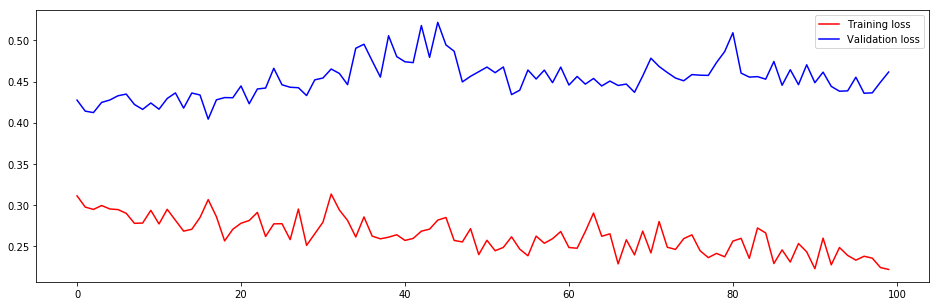

In [228]:
#Plot performance over epochs

#Create ticks on x axis from 0 through the number of epochs
x = np.arange(0,epochs)

lines = [loss_results,val_loss_results]
colors  = ['r','b']
labels  = ['Training loss','Validation loss']

# Adjust default plot size
plt.figure(figsize=(16,5))

for i,c,l in zip(lines,colors,labels):  
    plt.plot(x,i,c,label='l')
    plt.legend(labels)
               
plt.show()

Print results of all runs to help guide future model experimentation

In [229]:
#Save model performance to dataframe
model_perf_df.loc[len(model_perf_df)] = [format(best_loss, '.4f'), best_epoch, hidden_drop_out, kern_regularizer, act_regularizer, hidden_dense_size, hidden_activation, final_activation, batch_size, vars_used_str] 

#Print dataframe with model performance
print(model_perf_df.to_string(index=False))

BestLoss Epoch  Dropout        KerReg        ActReg HidDense HidAct   FinAct Batch                               Vars
 0.3711     3     0.25  0.000000e+00  0.000000e+00       32    elu  sigmoid   128  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.3783     4     0.25  1.000000e-05  1.000000e-05       32    elu  sigmoid   128  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.4085    48     0.25  0.000000e+00  1.000000e-05       32    elu  sigmoid   128  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.4153     4     0.35  0.000000e+00  0.000000e+00       32    elu  sigmoid   128  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.3783    24     0.30  1.000000e-05  1.000000e-06       32    elu  sigmoid   128  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.3827   166     0.25  1.000000e-05  1.000000e-06       64    elu  sigmoid   128  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.3988    47     0.25  1.000000e-05  1.000000e-06       32    elu  sigmoid    64  x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
 0.3826    90     0.25  1.000000e-05  1.000000e-06       32    

## Test model against test set
Test model against test set by rounding the predictions which are decimals to True / False values. Then, create an array which tracks whether or not the model predicted correctly predicted whether or not a location was a vineyard or not. 

In [230]:
# Import the saved test data
with open('vineyard_test.pkl', 'rb') as f: 
    is_vineyard_test, map_coords_test, elevation_test, wind_dir_test, wind_spd_test, precip_test, temp_test, min_temp_test, max_temp_test, clouds_test, ghi_test, rh_test = pickle.load(f)

#Replace none values in test data
replace_none([is_vineyard_test, map_coords_test, elevation_test, wind_dir_test, wind_spd_test, precip_test, temp_test, min_temp_test, max_temp_test, clouds_test, ghi_test, rh_test])
    
#get predictions with probability values
y_hat = model.predict([elevation_test, map_coords_test,wind_dir_test,wind_spd_test,precip_test, temp_test, min_temp_test, max_temp_test, clouds_test, ghi_test, rh_test], verbose=1)

#Round probabilities to 1s or 0s to test the accuracy of our train 
accuracy = np.array([])
i = 0
while i < len(y_hat):
    rounded_predict = round(y_hat[i][0])
    
    #Was the prediction correct?
    correct = rounded_predict == is_vineyard_test[i]
    accuracy = np.append(accuracy, correct)
    
    
    i = i +1

30/30 [==============================] - 4s 124ms/step


## Percent of locations classified correctly in our training set...

In [231]:
print('Correct responses = ' + str(np.mean(accuracy)))

Correct responses = 0.766666666667
